In [1]:
#Import 
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from scipy.linalg import norm


In [ ]:
from SGD_GD import stoch_grad
from L2regpb import L2regLS
from utils import generate_pb_parameters, generate_sparse_x,calculate_bound_sto_grad,calculate_c_S2GD,calculate_c_S2GD_uniform, get_an_approximate_sigma_sgd
from S2GD import S2GD
from SAGA import SAGA
from plot_iterations import plot_with_nb_gradients, plot_with_time

# Synthetic Least Squares

In [3]:
d = int(50)
n = int(25000)
lbda = 1. / n ** (0.5)
#lbda = 0
kappa = 1e3

np.random.seed(1)

# Ground truth coefficients of the model
x_model_truth = generate_sparse_x(d,sparsity=0.1)

A, y = generate_pb_parameters(x_model_truth, n, d, kappa,lbda, std=0, corr=0.7)
ylog = np.sign(y) # Taking the logarithm for binary classification
yone = np.copy(ylog)
yone[ylog==-1] = 0 
x0 = np.random.randn(d)
pbL2reg = L2regLS(A,y,lbda,'l2')

print(pbL2reg.fun(x_model_truth))

0.01739034982126003


In [4]:
x_sgd,obj_val_sgd,_,nb_comp_grad_sgd, times1 = stoch_grad(x0=x0,problem=pbL2reg,xtarget=x_model_truth,stepchoice=0,step0=3e-3, n_iter=3*1e6,nb=1,with_replace=False,verbose=True,fast=True)

Stochastic Gradient, batch size= 1 / 25000
  iter   |   fval   |  normit 
       0 | 7.17e+01 | 7.41e+00
   25000 | 6.62e-02 | 2.06e+00
   50000 | 3.78e-02 | 1.67e+00
   75000 | 2.99e-02 | 1.43e+00
  100000 | 2.60e-02 | 1.25e+00
  125000 | 2.36e-02 | 1.10e+00
  150000 | 2.20e-02 | 9.76e-01
  175000 | 2.09e-02 | 8.68e-01
  200000 | 2.01e-02 | 7.75e-01
  225000 | 1.95e-02 | 6.93e-01
  250000 | 1.91e-02 | 6.20e-01
  275000 | 1.87e-02 | 5.56e-01
  300000 | 1.84e-02 | 4.99e-01
  325000 | 1.82e-02 | 4.49e-01
  350000 | 1.80e-02 | 4.03e-01
  375000 | 1.79e-02 | 3.63e-01
  400000 | 1.78e-02 | 3.28e-01
  425000 | 1.77e-02 | 2.96e-01
  450000 | 1.76e-02 | 2.68e-01
  475000 | 1.76e-02 | 2.43e-01
  500000 | 1.75e-02 | 2.21e-01
  525000 | 1.75e-02 | 2.01e-01
  550000 | 1.75e-02 | 1.84e-01
  575000 | 1.74e-02 | 1.68e-01
  600000 | 1.74e-02 | 1.55e-01
  625000 | 1.74e-02 | 1.42e-01
  650000 | 1.74e-02 | 1.32e-01
  675000 | 1.74e-02 | 1.22e-01
  700000 | 1.74e-02 | 1.14e-01
  725000 | 1.74e-02 | 1.06e

In [5]:
x_s2gd,obj_val_s2gd,_,nb_comp_grad_s2gd, times2 = S2GD(x0=x0,problem=pbL2reg,xtarget=x_model_truth,h=-1,m=10,nu=pbL2reg.cvxval(),eps_tol=1e-12,n_iter=20,plus=False)

h= 0.001227501745607346 m= 41790 n_iter= 28
S2GD, n=25000. Exepcted number of inner loop at each iteration: 22037 in [20895,41790)
  iter   |   fval   |  normit  |    t    
       0 | 7.17e+01 | 7.41e+00 | 0.00e+00
       1 | 5.17e+00 | 2.98e+00 | 5.58e+03
       2 | 4.06e-01 | 1.44e+00 | 3.01e+04
       3 | 5.02e-02 | 1.12e+00 | 1.27e+04
       4 | 2.14e-02 | 6.72e-01 | 4.12e+04
       5 | 1.83e-02 | 4.32e-01 | 3.87e+04
       6 | 1.81e-02 | 4.22e-01 | 2.22e+03
       7 | 1.78e-02 | 3.27e-01 | 2.33e+04
       8 | 1.75e-02 | 2.39e-01 | 3.01e+04
       9 | 1.75e-02 | 2.34e-01 | 2.26e+03
      10 | 1.75e-02 | 2.33e-01 | 4.43e+02
      11 | 1.74e-02 | 1.58e-01 | 4.12e+04
      12 | 1.74e-02 | 1.28e-01 | 2.45e+04
      13 | 1.74e-02 | 1.01e-01 | 3.26e+04
      14 | 1.74e-02 | 8.52e-02 | 2.72e+04
      15 | 1.74e-02 | 7.98e-02 | 1.21e+04
      16 | 1.74e-02 | 7.58e-02 | 1.05e+04
      17 | 1.73e-02 | 7.21e-02 | 1.09e+04
      18 | 1.73e-02 | 6.29e-02 | 3.70e+04
      19 | 1.73e-02 | 5.83e-0

In [6]:
x_s2gd_plus,obj_val_s2gd_plus,_,nb_comp_grad_s2gd_plus, times3 = S2GD(x0=x0,problem=pbL2reg,xtarget=x_model_truth,h=-1,m=10,nu=pbL2reg.cvxval(),eps_tol=1e-12,n_iter=20,plus=True)

h= 0.001227501745607346 m= 41790 n_iter= 28
S2GD+, n= 25000 .  Number of inner loop at each iteration: 50000
Running a single pass of Stochastic Gradient:
  iter   |   fval   |  normit 
       0 | 7.17e+01 | 7.41e+00
       0 | 3.24e-02 | 1.52e+00
Running S2GD with t= 50000
  iter   |   fval   |  normit  |    t    
       0 | 3.24e-02 | 1.52e+00 | 0.00e+00
       1 | 2.05e-02 | 7.87e-01 | 5.00e+04
       2 | 1.82e-02 | 4.43e-01 | 5.00e+04
       3 | 1.76e-02 | 2.59e-01 | 5.00e+04
       4 | 1.74e-02 | 1.60e-01 | 5.00e+04
       5 | 1.74e-02 | 1.07e-01 | 5.00e+04
       6 | 1.74e-02 | 7.93e-02 | 5.00e+04
       7 | 1.73e-02 | 6.44e-02 | 5.00e+04
       8 | 1.73e-02 | 5.64e-02 | 5.00e+04
       9 | 1.73e-02 | 5.20e-02 | 5.00e+04
      10 | 1.73e-02 | 4.96e-02 | 5.00e+04
      11 | 1.73e-02 | 4.83e-02 | 5.00e+04
      12 | 1.73e-02 | 4.75e-02 | 5.00e+04
      13 | 1.73e-02 | 4.70e-02 | 5.00e+04
      14 | 1.73e-02 | 4.68e-02 | 5.00e+04
      15 | 1.73e-02 | 4.66e-02 | 5.00e+04
      16 | 

In [7]:
x_saga, obj_val_saga, _, nb_comp_grad_saga, times4 = SAGA(x0=x0,problem=pbL2reg,xtarget=x_model_truth,gamma=-1,eps_tol=1e-12,n_iter=3*1e6,verbose=True,fast=True)

SAGA, n=25000 with stepsize gamma = 0.0030026704851318317
  iter   |   fval   |  normit 
       0 | 7.17e+01 | 7.41e+00
   25000 | 3.08e-02 | 9.43e-01
   50000 | 2.64e-02 | 4.74e-01
   75000 | 1.85e-02 | 2.43e-01
  100000 | 1.83e-02 | 1.42e-01
  125000 | 1.78e-02 | 8.87e-02
  150000 | 1.75e-02 | 6.68e-02
  175000 | 1.74e-02 | 5.52e-02
  200000 | 1.74e-02 | 5.07e-02
  225000 | 1.74e-02 | 4.83e-02
  250000 | 1.74e-02 | 4.73e-02
  275000 | 1.74e-02 | 4.66e-02
  300000 | 1.73e-02 | 4.63e-02
  325000 | 1.73e-02 | 4.64e-02
  350000 | 1.73e-02 | 4.65e-02
  375000 | 1.73e-02 | 4.64e-02
  400000 | 1.73e-02 | 4.64e-02
  425000 | 1.73e-02 | 4.63e-02
  450000 | 1.73e-02 | 4.64e-02
  475000 | 1.73e-02 | 4.64e-02
  500000 | 1.73e-02 | 4.64e-02
  525000 | 1.73e-02 | 4.64e-02
  550000 | 1.73e-02 | 4.64e-02
  575000 | 1.73e-02 | 4.64e-02
  600000 | 1.73e-02 | 4.64e-02
  625000 | 1.73e-02 | 4.64e-02
  650000 | 1.73e-02 | 4.64e-02
  675000 | 1.73e-02 | 4.64e-02
  700000 | 1.73e-02 | 4.64e-02
  725000 | 1

In [148]:
sigma_sgd = get_an_approximate_sigma_sgd(pbL2reg,d,n,20)
nb_comp_grad_sgd_theory = np.arange(0,nb_comp_grad_saga[-1],1e2)
obj_val_sgd_theory = calculate_bound_sto_grad(3e-7,pbL2reg.lipgrad(),sigma_sgd,pbL2reg.cvxval(),obj_val_saga[-1],obj_val_sgd[0],nb_comp_grad_sgd_theory)

m = 41790
h = 0.001227
nu = pbL2reg.cvxval()
mu = pbL2reg.cvxval()
t_val = np.arange(1,m+1) 
t_probs = (1- nu*h)**(m-t_val)
beta = np.sum(t_probs)
c_S2GD = calculate_c_S2GD(pbL2reg.lipgrad(),nu,mu,h= h,m=m,beta = beta)
nb_comp_grad_s2gd_theory = np.arange(0,nb_comp_grad_saga[-1],1e2)
obj_val_s2gd_theory = c_S2GD**nb_comp_grad_s2gd_theory * (obj_val_saga[-1]-obj_val_s2gd[0])

2.3741533111195876


/var/folders/bt/7p2n2htn2jx9_bcbhdzps_gm0000gp/T/ipykernel_7048/848573744.py:14: RuntimeWarning: overflow encountered in power
  obj_val_s2gd_theory = c_S2GD**nb_comp_grad_s2gd_theory * (obj_val_saga[-1]-obj_val_s2gd[0])


In [144]:
#=====Parameters for plots ======
nb_gradients = [nb_comp_grad_s2gd_plus, nb_comp_grad_s2gd, nb_comp_grad_sgd, nb_comp_grad_saga,nb_comp_grad_sgd_theory]
obj_functions = [obj_val_s2gd_plus, obj_val_s2gd, obj_val_sgd, obj_val_saga, obj_val_sgd_theory]
name_of_models = ['S2GD+','S2GD', 'SGD', 'SAGA', 'SGD_theory']
list_times = [times3, times2, times1, times4]

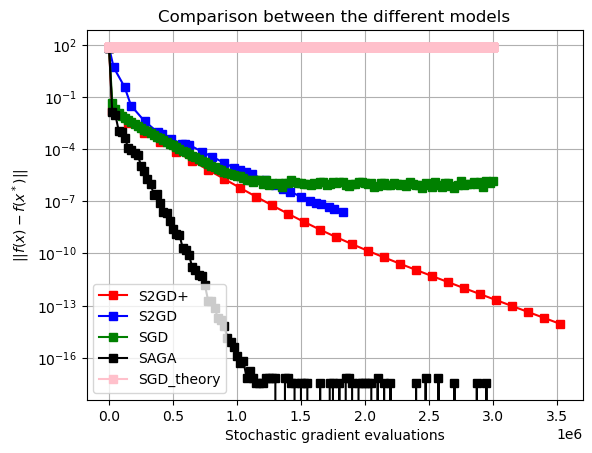

In [145]:
plot_with_nb_gradients(nb_gradients, obj_functions, name_of_models)

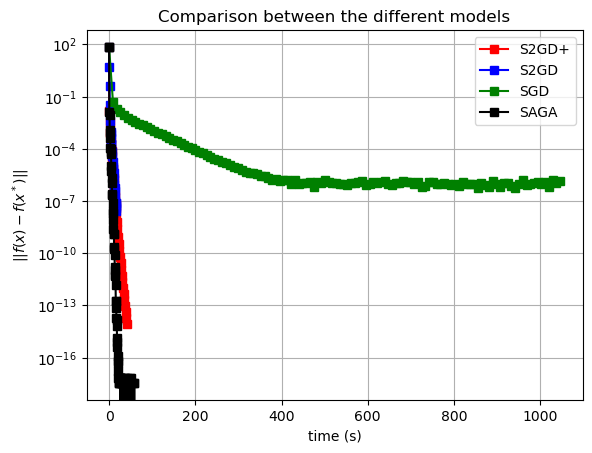

In [10]:
plot_with_time(list_times, obj_functions, name_of_models)

# MNIST logistic

In [11]:
def load_mnist_5_8():
    # Charger les datasets MNIST pour l'entraînement et le test
    mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
    mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
    
    # Filtrer les classes 5 et 8 pour l'entraînement
    train_indices_5_8 = np.where((mnist_train.targets == 5) | (mnist_train.targets == 8))[0]
    train_data_5_8 = mnist_train.data[train_indices_5_8]
    train_labels_5_8 = mnist_train.targets[train_indices_5_8]
    
    # Filtrer les classes 5 et 8 pour le test
    test_indices_5_8 = np.where((mnist_test.targets == 5) | (mnist_test.targets == 8))[0]
    test_data_5_8 = mnist_test.data[test_indices_5_8]
    test_labels_5_8 = mnist_test.targets[test_indices_5_8]
    
    # Convertir les labels en {0, 1} (5 -> -1, 8 -> 1)
    train_labels_5_8[train_labels_5_8 == 5] = -1
    train_labels_5_8[train_labels_5_8 == 8] = 1
    test_labels_5_8[test_labels_5_8 == 5] = -1
    test_labels_5_8[test_labels_5_8 == 8] = 1
    

    # Aplatir les images en vecteurs (28x28 -> 784) et normaliser
    train_A = train_data_5_8.view(train_data_5_8.size(0), -1).float() / 255.0
    test_A = test_data_5_8.view(test_data_5_8.size(0), -1).float() / 255.0
    # train_A = train_data_5_8.view(train_data_5_8.size(0), -1).float() 
    # test_A = test_data_5_8.view(test_data_5_8.size(0), -1).float() 

    # Ajouter une colonne de biais à chaque matrice
    # train_bias = torch.ones((train_A.size(0), 1))
    # test_bias = torch.ones((test_A.size(0), 1))
    # train_A = torch.cat((train_A, train_bias), dim=1)  # train_A de dimension (n_train, 785)
    # test_A = torch.cat((test_A, test_bias), dim=1)    # test_A de dimension (n_test, 785)
    
    # Retourner les données
    return train_A.numpy(), train_labels_5_8.numpy(), test_A.numpy(), test_labels_5_8.numpy()

# Charger les données
train_A, train_y, test_A, test_y = load_mnist_5_8()

In [12]:
lbda = 0.05
d = train_A.shape[1]
pblogreg = L2regLS(train_A,train_y,lbda,loss='logistic11')
pblogreg.kappa_val

239.1598365443281

In [13]:
x_star = np.random.randn(d)

In [33]:
x0 = np.random.randn(d)
x_sgd, obj_val_sgd,_, nb_comp_grad_sgd, times1 = stoch_grad(x0=x0,problem=pblogreg,xtarget=x_star,stepchoice=0,step0=1e-2, n_iter=1e6,nb=1,with_replace=False,verbose=True,fast=True)

Stochastic Gradient, batch size= 1 / 11272
  iter   |   fval   |  normit 
       0 | 2.01e+01 | 3.91e+01
   11272 | 7.26e+00 | 3.25e+01
   22544 | 2.89e+00 | 2.96e+01
   33816 | 1.26e+00 | 2.83e+01
   45088 | 6.52e-01 | 2.78e+01
   56360 | 4.20e-01 | 2.76e+01
   67632 | 3.32e-01 | 2.75e+01
   78904 | 2.99e-01 | 2.74e+01
   90176 | 2.85e-01 | 2.74e+01
  101448 | 2.81e-01 | 2.74e+01
  112720 | 2.78e-01 | 2.74e+01
  123992 | 2.78e-01 | 2.74e+01
  135264 | 2.78e-01 | 2.74e+01
  146536 | 2.78e-01 | 2.74e+01
  157808 | 2.78e-01 | 2.74e+01
  169080 | 2.77e-01 | 2.74e+01
  180352 | 2.77e-01 | 2.74e+01
  191624 | 2.77e-01 | 2.74e+01
  202896 | 2.78e-01 | 2.74e+01
  214168 | 2.82e-01 | 2.74e+01
  225440 | 2.78e-01 | 2.74e+01
  236712 | 2.77e-01 | 2.74e+01
  247984 | 2.77e-01 | 2.74e+01
  259256 | 2.78e-01 | 2.74e+01
  270528 | 2.77e-01 | 2.74e+01
  281800 | 2.78e-01 | 2.74e+01
  293072 | 2.77e-01 | 2.74e+01
  304344 | 2.78e-01 | 2.74e+01
  315616 | 2.77e-01 | 2.73e+01
  326888 | 2.78e-01 | 2.74e

In [30]:
x_s2gd,obj_val_s2gd,_,nb_comp_grad_s2gd, times2 = S2GD(x0=x0,problem=pblogreg,xtarget=x_star,h=-1,m=10,nu=pblogreg.cvxval(),eps_tol=1e-25,n_iter=30,plus=False)

h= 0.0006560611183590078 m= 10074 n_iter= 58
S2GD, n=11272. Exepcted number of inner loop at each iteration: 5314 in [5037,10074)
  iter   |   fval   |  normit  |    t    
       0 | 2.59e+01 | 4.02e+01 | 0.00e+00
       1 | 1.73e+01 | 3.80e+01 | 3.20e+03
       2 | 9.81e+00 | 3.42e+01 | 7.89e+03
       3 | 7.04e+00 | 3.25e+01 | 4.96e+03
       4 | 4.02e+00 | 3.05e+01 | 8.64e+03
       5 | 3.50e+00 | 3.01e+01 | 2.20e+03
       6 | 2.60e+00 | 2.94e+01 | 4.86e+03
       7 | 2.25e+00 | 2.92e+01 | 2.38e+03
       8 | 1.55e+00 | 2.86e+01 | 6.45e+03
       9 | 1.28e+00 | 2.84e+01 | 3.58e+03
      10 | 7.87e-01 | 2.80e+01 | 1.00e+04
      11 | 5.47e-01 | 2.77e+01 | 9.45e+03
      12 | 4.98e-01 | 2.77e+01 | 2.96e+03
      13 | 4.00e-01 | 2.76e+01 | 8.75e+03
      14 | 3.46e-01 | 2.75e+01 | 8.62e+03
      15 | 3.25e-01 | 2.75e+01 | 5.32e+03
      16 | 3.10e-01 | 2.74e+01 | 5.71e+03
      17 | 2.98e-01 | 2.74e+01 | 6.44e+03
      18 | 2.95e-01 | 2.74e+01 | 2.73e+03
      19 | 2.91e-01 | 2.74e+01

In [18]:
x_s2gd_plus,obj_val_s2gd_plus,_,nb_comp_grad_s2gd_plus, times3 = S2GD(x0=x0,problem=pblogreg,xtarget=x_star,h=-1,m=10,nu=pblogreg.cvxval(),eps_tol=1e-15,n_iter=30,plus=True)

h= 0.0006592042022967511 m= 9995 n_iter= 35
S2GD+, n= 11272 .  Number of inner loop at each iteration: 22544
Running a single pass of Stochastic Gradient:
  iter   |   fval   |  normit 
       0 | 2.59e+01 | 4.02e+01
       0 | 9.64e+00 | 3.41e+01
Running S2GD with t= 22544
  iter   |   fval   |  normit  |    t    
       0 | 9.64e+00 | 3.41e+01 | 0.00e+00
       1 | 2.27e+00 | 2.92e+01 | 2.25e+04
       2 | 7.10e-01 | 2.79e+01 | 2.25e+04
       3 | 3.71e-01 | 2.75e+01 | 2.25e+04
       4 | 2.98e-01 | 2.74e+01 | 2.25e+04
       5 | 2.81e-01 | 2.74e+01 | 2.25e+04
       6 | 2.78e-01 | 2.74e+01 | 2.25e+04
       7 | 2.77e-01 | 2.74e+01 | 2.25e+04
       8 | 2.77e-01 | 2.74e+01 | 2.25e+04
       9 | 2.77e-01 | 2.74e+01 | 2.25e+04
      10 | 2.77e-01 | 2.74e+01 | 2.25e+04
      11 | 2.77e-01 | 2.74e+01 | 2.25e+04
      12 | 2.77e-01 | 2.74e+01 | 2.25e+04
      13 | 2.77e-01 | 2.74e+01 | 2.25e+04
      14 | 2.77e-01 | 2.74e+01 | 2.25e+04
      15 | 2.77e-01 | 2.74e+01 | 2.25e+04
      16 | 

In [27]:
x_saga,obj_val_saga,_,nb_comp_grad_saga, times4 = SAGA(x0,pblogreg,x_star,-1,1e-10,1.5*1e6,fast=True)

SAGA, n=11272 with stepsize gamma = 0.0008687221915078557
  iter   |   fval   |  normit 
       0 | 2.59e+01 | 4.02e+01
   11272 | 7.61e+00 | 3.28e+01
   22544 | 2.91e+00 | 2.97e+01
   33816 | 1.24e+00 | 2.83e+01
   45088 | 6.33e-01 | 2.78e+01
   56360 | 4.07e-01 | 2.76e+01
   67632 | 3.24e-01 | 2.75e+01
   78904 | 2.94e-01 | 2.74e+01
   90176 | 2.83e-01 | 2.74e+01
  101448 | 2.79e-01 | 2.74e+01
  112720 | 2.78e-01 | 2.74e+01
  123992 | 2.77e-01 | 2.74e+01
  135264 | 2.77e-01 | 2.74e+01
  146536 | 2.77e-01 | 2.74e+01
  157808 | 2.77e-01 | 2.74e+01
  169080 | 2.77e-01 | 2.74e+01
  180352 | 2.77e-01 | 2.74e+01
  191624 | 2.77e-01 | 2.74e+01
  202896 | 2.77e-01 | 2.74e+01
  214168 | 2.77e-01 | 2.74e+01
  225440 | 2.77e-01 | 2.74e+01
  236712 | 2.77e-01 | 2.74e+01
  247984 | 2.77e-01 | 2.74e+01
  259256 | 2.77e-01 | 2.74e+01
  270528 | 2.77e-01 | 2.74e+01
  281800 | 2.77e-01 | 2.74e+01
  293072 | 2.77e-01 | 2.74e+01
  304344 | 2.77e-01 | 2.74e+01
  315616 | 2.77e-01 | 2.74e+01
  326888 | 2

In [37]:
#=====Parameters for plots ======
nb_gradients = [nb_comp_grad_s2gd_plus, nb_comp_grad_s2gd, nb_comp_grad_sgd, nb_comp_grad_saga]
obj_functions = [obj_val_s2gd_plus, obj_val_s2gd, obj_val_sgd[1:], obj_val_saga]
name_of_models = ['S2GD+','S2GD', 'SGD', 'SAGA']
list_times = [times3, times2, times1[1:], times4]

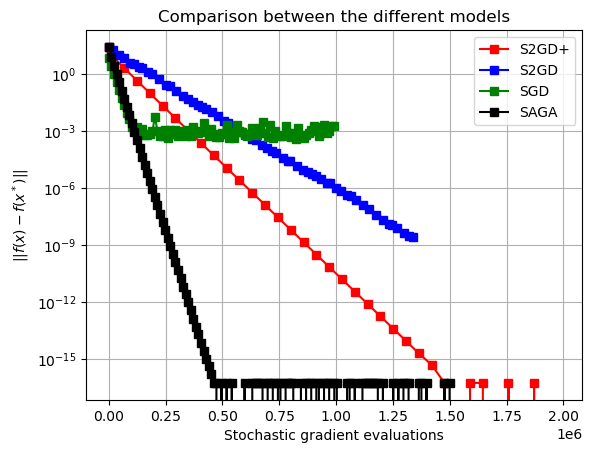

In [38]:
plot_with_nb_gradients(nb_gradients, obj_functions, name_of_models)

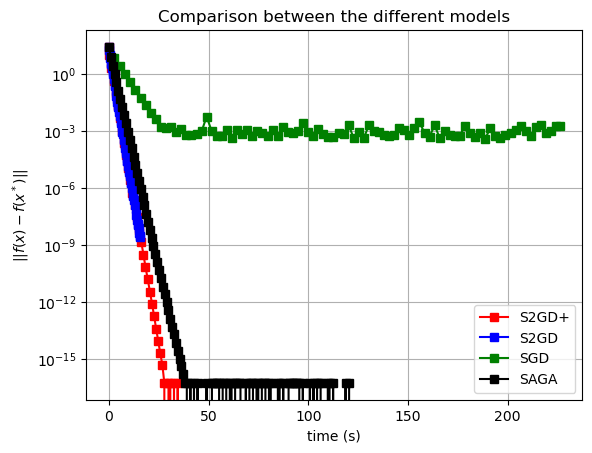

In [39]:
plot_with_time(list_times, obj_functions, name_of_models)

In [40]:
error_s2gd = 0
error_sgd = 0
error_s2gd_plus = 0
error_saga = 0
for  i in range(len(test_y)):
    if np.sign(np.dot(test_A,x_s2gd))[i] != test_y[i] : 
        error_s2gd += 1
    if np.sign(np.dot(test_A,x_sgd))[i] != test_y[i] : 
        error_sgd += 1
    if np.sign(np.dot(test_A,x_s2gd_plus))[i] != test_y[i] : 
        error_s2gd_plus += 1
    if np.sign(np.dot(test_A,x_saga))[i] != test_y[i] : 
        error_saga += 1
error_s2gd /= len(test_y)
error_sgd /= len(test_y)
error_s2gd_plus /= len(test_y)
error_saga /= len(test_y)
error_s2gd, error_sgd, error_s2gd_plus , error_saga

(0.05466237942122187,
 0.05466237942122187,
 0.05466237942122187,
 0.05466237942122187)

## Test avec un très fort conditionnement

In [54]:
d = int(10)
n = int(2000)
lbda = 1. / n ** (0.5)
#lbda = 0
kappa = 1e5

np.random.seed(1)

# Ground truth coefficients of the model
x_model_truth = generate_sparse_x(d,sparsity=0.01)

A, y = generate_pb_parameters(x_model_truth, n, d, kappa,lbda, std=0, corr=0.7)
ylog = np.sign(y) # Taking the logarithm for binary classification
yone = np.copy(ylog)
yone[ylog==-1] = 0 
x0 = np.random.randn(d)
pbL2reg = L2regLS(A,y,lbda,'l2')

print(pbL2reg.kappa_val)

99999.99999999967


In [99]:
x_sgd,obj_val_sgd,_,nb_comp_grad_sgd, times1 = stoch_grad(x0=x0,problem=pbL2reg,xtarget=x_model_truth,stepchoice=0,step0=3e-3, n_iter=5e6,nb=1,with_replace=False,verbose=True,fast=True)

Stochastic Gradient, batch size= 1 / 2000
  iter   |   fval   |  normit 
       0 | 6.24e+03 | 3.25e+00
    2000 | 3.40e+01 | 1.40e+00
    4000 | 8.01e+00 | 1.34e+00
    6000 | 4.23e+00 | 1.31e+00
    8000 | 2.42e+00 | 1.30e+00
   10000 | 1.37e+00 | 1.29e+00
   12000 | 8.14e-01 | 1.29e+00
   14000 | 5.10e-01 | 1.29e+00
   16000 | 3.39e-01 | 1.29e+00
   18000 | 2.37e-01 | 1.29e+00
   20000 | 1.79e-01 | 1.29e+00
   22000 | 1.45e-01 | 1.29e+00
   24000 | 1.23e-01 | 1.28e+00
   26000 | 1.10e-01 | 1.28e+00
   28000 | 1.02e-01 | 1.28e+00
   30000 | 9.55e-02 | 1.28e+00
   32000 | 9.09e-02 | 1.28e+00
   34000 | 8.76e-02 | 1.28e+00
   36000 | 8.49e-02 | 1.28e+00
   38000 | 8.28e-02 | 1.28e+00
   40000 | 8.10e-02 | 1.28e+00
   42000 | 7.95e-02 | 1.28e+00
   44000 | 7.82e-02 | 1.28e+00
   46000 | 7.71e-02 | 1.28e+00
   48000 | 7.62e-02 | 1.28e+00
   50000 | 7.54e-02 | 1.28e+00
   52000 | 7.47e-02 | 1.28e+00
   54000 | 7.41e-02 | 1.28e+00
   56000 | 7.37e-02 | 1.28e+00
   58000 | 7.32e-02 | 1.28e+

In [106]:
x_s2gd_plus,obj_val_s2gd_plus,_,nb_comp_grad_s2gd_plus, times3 = S2GD(x0=x0,problem=pbL2reg,xtarget=x_model_truth,h=3.55*1e-6,m=381375,nu=pbL2reg.cvxval(),eps_tol=1e-6,n_iter=20,plus=False,alpha=2)

S2GD, n=2000. Exepcted number of inner loop at each iteration: 191693 in [190688,381375)
  iter   |   fval   |  normit  |    t    
       0 | 6.24e+03 | 3.25e+00 | 0.00e+00
       1 | 5.59e+01 | 1.36e+00 | 8.97e+04
       2 | 7.59e-01 | 1.25e+00 | 2.76e+05
       3 | 9.49e-02 | 1.24e+00 | 1.07e+05
       4 | 6.90e-02 | 1.22e+00 | 1.93e+05
       5 | 6.82e-02 | 1.19e+00 | 2.43e+05
       6 | 6.79e-02 | 1.19e+00 | 1.03e+05
       7 | 6.71e-02 | 1.15e+00 | 3.56e+05
       8 | 6.63e-02 | 1.12e+00 | 3.46e+05
       9 | 6.55e-02 | 1.09e+00 | 3.63e+05
      10 | 6.51e-02 | 1.07e+00 | 2.28e+05
      11 | 6.47e-02 | 1.06e+00 | 1.89e+05
      12 | 6.41e-02 | 1.03e+00 | 3.44e+05
      13 | 6.35e-02 | 1.00e+00 | 3.58e+05
      14 | 6.34e-02 | 9.98e-01 | 2.06e+04
      15 | 6.29e-02 | 9.72e-01 | 3.47e+05
      16 | 6.28e-02 | 9.70e-01 | 2.25e+04
      17 | 6.26e-02 | 9.58e-01 | 1.67e+05
      18 | 6.22e-02 | 9.42e-01 | 2.13e+05
      19 | 6.22e-02 | 9.41e-01 | 2.31e+04
      20 | 6.21e-02 | 9.35e-0

In [100]:
x_saga,obj_val_saga,_,nb_comp_grad_saga, times4 = SAGA(x0,pbL2reg,x_model_truth,0.00001,1e-10,5e6,fast=True)

SAGA, n=2000 with stepsize gamma = 1e-05
  iter   |   fval   |  normit 
       0 | 6.24e+03 | 3.25e+00
    2000 | 1.42e+00 | 1.29e+00
    4000 | 6.30e-01 | 1.28e+00
    6000 | 8.86e-01 | 1.28e+00
    8000 | 1.24e-01 | 1.28e+00
   10000 | 8.11e-02 | 1.28e+00
   12000 | 7.40e-02 | 1.28e+00
   14000 | 7.15e-02 | 1.28e+00
   16000 | 7.07e-02 | 1.28e+00
   18000 | 7.07e-02 | 1.28e+00
   20000 | 7.05e-02 | 1.28e+00
   22000 | 7.04e-02 | 1.28e+00
   24000 | 7.04e-02 | 1.28e+00
   26000 | 7.04e-02 | 1.28e+00
   28000 | 7.04e-02 | 1.28e+00
   30000 | 7.04e-02 | 1.28e+00
   32000 | 7.03e-02 | 1.28e+00
   34000 | 7.03e-02 | 1.27e+00
   36000 | 7.03e-02 | 1.27e+00
   38000 | 7.03e-02 | 1.27e+00
   40000 | 7.03e-02 | 1.27e+00
   42000 | 7.03e-02 | 1.27e+00
   44000 | 7.03e-02 | 1.27e+00
   46000 | 7.02e-02 | 1.27e+00
   48000 | 7.02e-02 | 1.27e+00
   50000 | 7.02e-02 | 1.27e+00
   52000 | 7.02e-02 | 1.27e+00
   54000 | 7.02e-02 | 1.27e+00
   56000 | 7.02e-02 | 1.27e+00
   58000 | 7.01e-02 | 1.27e+0

In [107]:
#=====Parameters for plots ======
nb_gradients = [nb_comp_grad_s2gd_plus,  nb_comp_grad_sgd, nb_comp_grad_saga]
obj_functions = [obj_val_s2gd_plus, obj_val_sgd, obj_val_saga]
name_of_models = ['S2GD+', 'SGD', 'SAGA']
list_times = [times3, times1, times4]

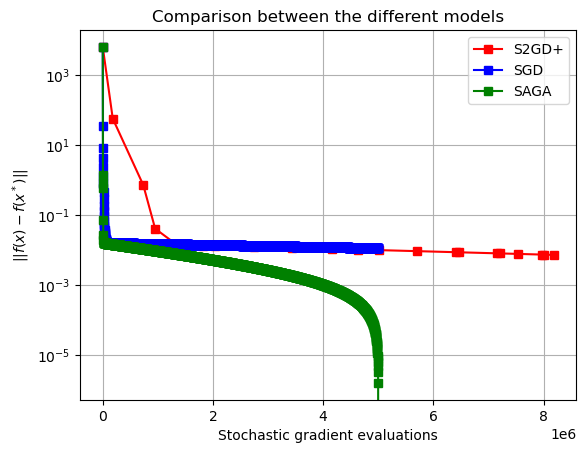

In [111]:
plot_with_nb_gradients(nb_gradients, obj_functions, name_of_models)